# Data Preparation for CNNMO Side-Channel Attack

This notebook loads datasets (ASCAD or AES_PTv2_Pinata), normalizes traces, and generates labels for all 256 key hypotheses.


In [38]:
import h5py
import numpy as np
import torch
from pathlib import Path


## 1. AES S-box Definition


In [39]:
# AES S-box lookup table
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)


## 2. Dataset Configuration

Select which dataset to use:
- `ascad`: ASCAD dataset (from ASCAD.h5 or ASCADv1/ASCAD.h5)
- `pinata_ms1`: AES_PTv2_Pinata MS1 variant
- `pinata_ms2`: AES_PTv2_Pinata MS2 variant  
- `pinata_unprotected`: AES_PTv2_Pinata Unprotected variant


In [40]:
# Dataset configuration
DATASET_NAME = "pinata_unprotected"  # Options: "ascad", "pinata_ms1", "pinata_ms2", "pinata_unprotected"
TARGET_BYTE = 2  # Which byte to attack (0-15)

# Dataset paths
if DATASET_NAME == "ascad":
    dataset_path = Path("datasets/ASCADv1/ASCAD.h5")
elif DATASET_NAME.startswith("pinata"):
    dataset_path = Path("datasets/AES_PTv2_Pinata.h5")
else:
    raise ValueError(f"Unknown dataset: {DATASET_NAME}")

print(f"Using dataset: {DATASET_NAME}")
print(f"Dataset path: {dataset_path}")
print(f"Target byte: {TARGET_BYTE}")


Using dataset: pinata_unprotected
Dataset path: datasets/AES_PTv2_Pinata.h5
Target byte: 2


In [41]:
# Load dataset based on type
def load_ascad_dataset(file_path):
    """Load ASCAD dataset format."""
    with h5py.File(file_path, "r") as f:
        traces = f["Profiling_traces/traces"][:]
        metadata = f["Profiling_traces/metadata"][:]
        attack_traces = f["Attack_traces/traces"][:]
        attack_metadata = f["Attack_traces/metadata"][:]
    return traces, metadata, attack_traces, attack_metadata

def load_pinata_dataset(file_path, variant="Unprotected"):
    """Load Pinata dataset format.
    
    Args:
        file_path: Path to AES_PTv2_Pinata.h5
        variant: "MS1", "MS2", or "Unprotected"
    """
    with h5py.File(file_path, "r") as f:
        profiling_group = f[f"Pinata/{variant}/Profiling"]
        attack_group = f[f"Pinata/{variant}/Attack"]
        
        traces = profiling_group["Traces"][:]
        metadata = profiling_group["MetaData"][:]
        attack_traces = attack_group["Traces"][:]
        attack_metadata = attack_group["MetaData"][:]
        
        # Pinata has labels, but we'll generate our own for consistency
        # profiling_labels = profiling_group["Labels"][:]
        # attack_labels = attack_group["Labels"][:]
    
    return traces, metadata, attack_traces, attack_metadata

# Load the dataset
if DATASET_NAME == "ascad":
    traces, metadata, attack_traces, attack_metadata = load_ascad_dataset(dataset_path)
elif DATASET_NAME == "pinata_ms1":
    traces, metadata, attack_traces, attack_metadata = load_pinata_dataset(dataset_path, "MS1")
elif DATASET_NAME == "pinata_ms2":
    traces, metadata, attack_traces, attack_metadata = load_pinata_dataset(dataset_path, "MS2")
elif DATASET_NAME == "pinata_unprotected":
    traces, metadata, attack_traces, attack_metadata = load_pinata_dataset(dataset_path, "Unprotected")
else:
    raise ValueError(f"Unknown dataset: {DATASET_NAME}")

print("=== Profiling Data (Training) ===")
print(f"Traces shape: {traces.shape}")
print(f"Metadata fields: {metadata.dtype.names}")
print(f"Number of traces: {len(traces)}")

print("\n=== Attack Data (Evaluation) ===")
print(f"Attack traces shape: {attack_traces.shape}")
print(f"Number of attack traces: {len(attack_traces)}")


=== Profiling Data (Training) ===
Traces shape: (100000, 1260)
Metadata fields: ('plaintext', 'key')
Number of traces: 100000

=== Attack Data (Evaluation) ===
Attack traces shape: (50000, 1260)
Number of attack traces: 50000


In [42]:
# Extract plaintext and key from metadata
# Both ASCAD and Pinata have plaintext and key in metadata

# Profiling data (keys may vary for non-profiled setting)
plaintexts = metadata["plaintext"][:, TARGET_BYTE]
keys = metadata["key"][:, TARGET_BYTE]
profiling_keys_unique = np.unique(keys)

# Attack data (should have a fixed secret key)
attack_plaintexts = attack_metadata["plaintext"][:, TARGET_BYTE]
attack_keys = attack_metadata["key"][:, TARGET_BYTE]
attack_keys_unique = np.unique(attack_keys)

if len(attack_keys_unique) != 1:
    raise ValueError(f"Attack keys are not constant for target byte {TARGET_BYTE}: {attack_keys_unique[:5]}")
true_key = int(attack_keys_unique[0])

print("=== Profiling Data ===")
print(f"Plaintexts shape: {plaintexts.shape}")
print(f"Profiling keys unique count: {len(profiling_keys_unique)}")
print(f"Profiling keys (first 5): {profiling_keys_unique[:5]}")

print("\n=== Attack Data ===")
print(f"Attack plaintexts shape: {attack_plaintexts.shape}")
print(f"Attack key byte (fixed): {true_key} (0x{true_key:02x})")
print(f"All attack keys same: {len(attack_keys_unique) == 1}")


=== Profiling Data ===
Plaintexts shape: (100000,)
Profiling keys unique count: 256
Profiling keys (first 5): [0 1 2 3 4]

=== Attack Data ===
Attack plaintexts shape: (50000,)
Attack key byte (fixed): 186 (0xba)
All attack keys same: True


## 3. Normalize Traces

Following Timon's approach:
1. Remove the mean of all traces
2. Scale each sample to [-1, 1]


In [43]:
def normalize_traces(traces):
    """Normalize traces: center and scale to [-1, 1]"""
    # Remove global mean
    traces = traces - np.mean(traces)
    
    # Scale to [-1, 1]
    max_val = np.max(np.abs(traces))
    if max_val > 0:
        traces = traces / max_val
    
    return traces.astype(np.float32)

# Normalize profiling traces
traces_norm = normalize_traces(traces)
print(f"Profiling traces - min: {traces_norm.min():.4f}, max: {traces_norm.max():.4f}")

# Normalize attack traces
attack_traces_norm = normalize_traces(attack_traces)
print(f"Attack traces - min: {attack_traces_norm.min():.4f}, max: {attack_traces_norm.max():.4f}")


Profiling traces - min: -0.9025, max: 1.0000
Attack traces - min: -0.8490, max: 1.0000


## 4. Generate Multi-Output Labels

For each trace and each key hypothesis (0-255), compute:
$$l_{i,k} = \text{LSB}(\text{Sbox}(p_i \oplus k))$$


In [44]:
def generate_labels(plaintexts, sbox):
    """
    Generate 256-column label matrix.
    
    For each trace i and key hypothesis k:
    label[i, k] = LSB(Sbox(plaintext[i] XOR k))
    
    Returns: (N, 256) array of 0/1 labels
    """
    n_traces = len(plaintexts)
    labels = np.zeros((n_traces, 256), dtype=np.int64)
    
    for k in range(256):
        # XOR plaintext with key hypothesis
        intermediate = plaintexts ^ k
        # Apply S-box
        sbox_out = sbox[intermediate]
        # Take LSB
        labels[:, k] = sbox_out & 1
    
    return labels

# Generate labels for profiling traces
labels = generate_labels(plaintexts, SBOX)
print(f"Profiling labels shape: {labels.shape}")
print(f"Label distribution for key 0: {np.bincount(labels[:, 0])}")

# Generate labels for attack traces
attack_labels = generate_labels(attack_plaintexts, SBOX)
print(f"\nAttack labels shape: {attack_labels.shape}")
print(f"Attack label distribution for key 0: {np.bincount(attack_labels[:, 0])}")


Profiling labels shape: (100000, 256)
Label distribution for key 0: [50268 49732]

Attack labels shape: (50000, 256)
Attack label distribution for key 0: [24910 25090]


In [45]:
# Verify: the correct key hypothesis should have labels that correlate with actual leakage
print(f"True key byte (from attack set): {true_key}")
print(f"Labels for true key - unique values: {np.unique(labels[:, true_key])}")
print(f"Labels for true key - distribution: {np.bincount(labels[:, true_key])}")

if len(profiling_keys_unique) != 1:
    print("Warning: profiling keys vary (non-profiled scenario). True key printed above comes from attack set.")


True key byte (from attack set): 186
Labels for true key - unique values: [0 1]
Labels for true key - distribution: [50082 49918]


## 5. Limit Dataset Size

The paper uses 20,000 traces.


In [46]:
# Changed from 20k
N_TRACES = min(50000, len(traces_norm))

traces_subset = traces_norm[:N_TRACES]
labels_subset = labels[:N_TRACES]

print(f"Using {N_TRACES} traces")
print(f"Traces shape: {traces_subset.shape}")
print(f"Labels shape: {labels_subset.shape}")


Using 50000 traces
Traces shape: (50000, 1260)
Labels shape: (50000, 256)


## 6. Save Preprocessed Data


In [47]:
# Convert to PyTorch tensors
traces_tensor = torch.from_numpy(traces_subset)
labels_tensor = torch.from_numpy(labels_subset)

# Convert attack data to PyTorch tensors
attack_traces_tensor = torch.from_numpy(attack_traces_norm)
attack_labels_tensor = torch.from_numpy(attack_labels)
attack_plaintexts_tensor = torch.from_numpy(attack_plaintexts.astype(np.int64))

# Generate output filename based on dataset
output_filename = f"{DATASET_NAME}_preprocessed.pt"

# Save for training notebook
data = {
    # Training data (profiling traces)
    "traces": traces_tensor,
    "labels": labels_tensor,
    # Attack data (for evaluation)
    "attack_traces": attack_traces_tensor,
    "attack_labels": attack_labels_tensor,
    "attack_plaintexts": attack_plaintexts_tensor,
    # Metadata
    "true_key": true_key,  # From attack set (fixed secret)
    "profiling_keys_unique": profiling_keys_unique,
    "n_traces": N_TRACES,
    "n_attack_traces": len(attack_traces_norm),
    "dataset_name": DATASET_NAME,
    "target_byte": TARGET_BYTE
}

torch.save(data, output_filename)
print(f"Saved preprocessed data to {output_filename}")
print(f"\n=== Training Data ===")
print(f"  - traces: {traces_tensor.shape}")
print(f"  - labels: {labels_tensor.shape}")
print(f"\n=== Attack Data ===")
print(f"  - attack_traces: {attack_traces_tensor.shape}")
print(f"  - attack_labels: {attack_labels_tensor.shape}")
print(f"  - attack_plaintexts: {attack_plaintexts_tensor.shape}")
print(f"\n=== Metadata ===")
print(f"  - true_key: {true_key}")
print(f"  - dataset: {DATASET_NAME}")
print(f"  - target_byte: {TARGET_BYTE}")


Saved preprocessed data to pinata_unprotected_preprocessed.pt

=== Training Data ===
  - traces: torch.Size([50000, 1260])
  - labels: torch.Size([50000, 256])

=== Attack Data ===
  - attack_traces: torch.Size([50000, 1260])
  - attack_labels: torch.Size([50000, 256])
  - attack_plaintexts: torch.Size([50000])

=== Metadata ===
  - true_key: 186
  - dataset: pinata_unprotected
  - target_byte: 2


## 7. Quick Visualization


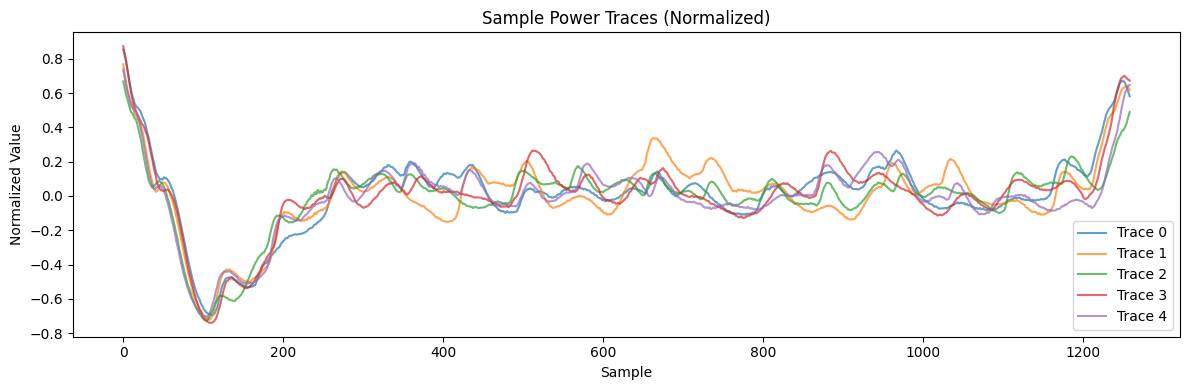

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
for i in range(5):
    ax.plot(traces_subset[i], alpha=0.7, label=f"Trace {i}")
ax.set_xlabel("Sample")
ax.set_ylabel("Normalized Value")
ax.set_title("Sample Power Traces (Normalized)")
ax.legend()
plt.tight_layout()
plt.show()
